# Vector AI Forecasting Bootcamp (WC code)

## TD Team 2

### M5 dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import os
import torch
import pytorch_lightning as pl
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting.metrics import NormalDistributionLoss
from pytorch_forecasting import TimeSeriesDataSet, Baseline, DeepAR, GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting import NBeats
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# !ls /ssd003/projects/forecasting_bootcamp/bootcamp_datasets

In [2]:
sales_train_val = pd.read_csv('/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/m5-forecasting-accuracy/sales_train_evaluation.csv')
sales_train_val.name = 'sales'

In [3]:
df1 = sales_train_val[(sales_train_val.state_id=='CA') & (sales_train_val.dept_id=='HOBBIES_2')]
items = df1.item_id.unique()
items = [i for i in items if i[-3:-1] == '00' or i[-3:] == '010']
df1 = df1[df1.item_id.isin(items)]
df1 = df1[[c for c in df1.columns if 'd_' in c or 'item_id' in c]]
df1 = df1.groupby('item_id').sum()
df1.shape

(10, 1941)

<AxesSubplot:>

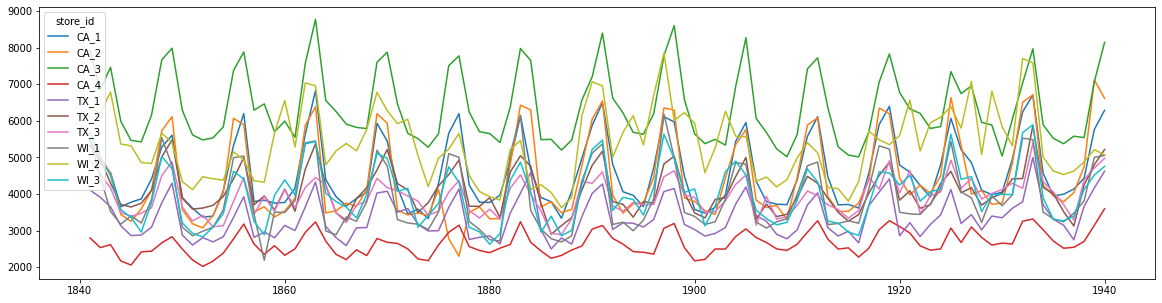

In [4]:
df = sales_train_val.groupby('store_id').sum().T
df = df.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(20,5))
df.iloc[-100:].plot(ax=ax)

In [5]:
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
train_dataset = sales_train_val.groupby('store_id').sum()[d_cols[-100:-30]]
val_dataset = sales_train_val.groupby('store_id').sum()[d_cols[-30:]]

In [6]:
# model settings

EPOCHS = 5
VAL_PERC = .1 
TEST_PERC = .05
BATCH_SIZE = 32

LAG_TIME = 30
LEAD_TIME = 30

In [7]:
# data splitting
n_samples = len(df)
n_val = int(n_samples * VAL_PERC)
n_test = int(n_samples * TEST_PERC)
n_train = n_samples - (n_val + n_test)

# Split data into train and test
train_df = df.iloc[:n_train, :]
val_df = df.iloc[n_train:n_train+n_val]
test_df = df.iloc[n_train+n_val:]

In [8]:
# Rename index to time_idx
train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
val_df = val_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)

# Add group id column and initialize with 0
train_df['group_ids'] = 0
val_df['group_ids'] = 0
test_df['group_ids'] = 0

In [9]:
# Reshape  data into single value column that is uniquely indexed by pairs of (time_idx, group_ids).
train_df = train_df.melt(id_vars=['time_idx'], value_vars=df.columns, var_name='group_ids')
val_df = val_df.melt(id_vars=['time_idx'], value_vars=df.columns, var_name='group_ids')
test_df = test_df.melt(id_vars=['time_idx'], value_vars=df.columns, var_name='group_ids')

In [10]:
train_df['value'] = train_df['value'].astype(float)
val_df['value'] = val_df['value'].astype(float)
test_df['value'] = test_df['value'].astype(float)

In [11]:
# Define datasets
train_data = TimeSeriesDataSet(
    data=train_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
)

val_data = TimeSeriesDataSet(
    data=val_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(val_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
)

test_data = TimeSeriesDataSet(
    data=test_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(test_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
)

In [12]:
# Define dataloaders
train_dataloader = train_data.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=8)
val_dataloader = val_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=8)
test_dataloader = test_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=8)

In [13]:
train_df.dtypes

time_idx       int64
group_ids     object
value        float64
dtype: object

In [14]:
# Init model with structure specified in dataset
net = NBeats.from_dataset(
    train_data,
    learning_rate=1e-4,
    weight_decay=1e-2
)

# Set random seed 
pl.seed_everything(42)

# Define early stopping criteria
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

# Init pytorch lightning trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    gpus=1,
    weights_summary="top",
    callbacks=[early_stop_callback],
    limit_train_batches=.2,
    limit_val_batches=.2,
)


# Train and Validate Model
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.717     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [15]:
# Load best model from checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [16]:
# Get predictions from test dataset
preds = best_model.predict(test_dataloader)

# Aggregate inputs, ground truth and classes into tensor alligned with predictions
input_list, true_list, class_list = [], [], []
for x, y in test_dataloader: 
    input_list.append(x["encoder_target"])
    true_list.append(y[0])
    class_list.append(x["groups"])


inputs = torch.cat(input_list)
trues = torch.cat(true_list)
classes = torch.cat(class_list)

print(inputs.shape, preds.shape, trues.shape, classes.shape)

torch.Size([380, 30]) torch.Size([380, 30]) torch.Size([380, 30]) torch.Size([380, 1])


In [17]:
# Select indices of samples to visualize
n_samples = 10
ss_indices = np.random.choice(range(preds.shape[0]), n_samples, replace=False)
ss_pred = preds[ss_indices]
ss_true = trues[ss_indices]
ss_input = inputs[ss_indices]
ss_class = classes[ss_indices]

print(ss_input.shape, ss_pred.shape, ss_true.shape, ss_class.shape)

torch.Size([10, 30]) torch.Size([10, 30]) torch.Size([10, 30]) torch.Size([10, 1])


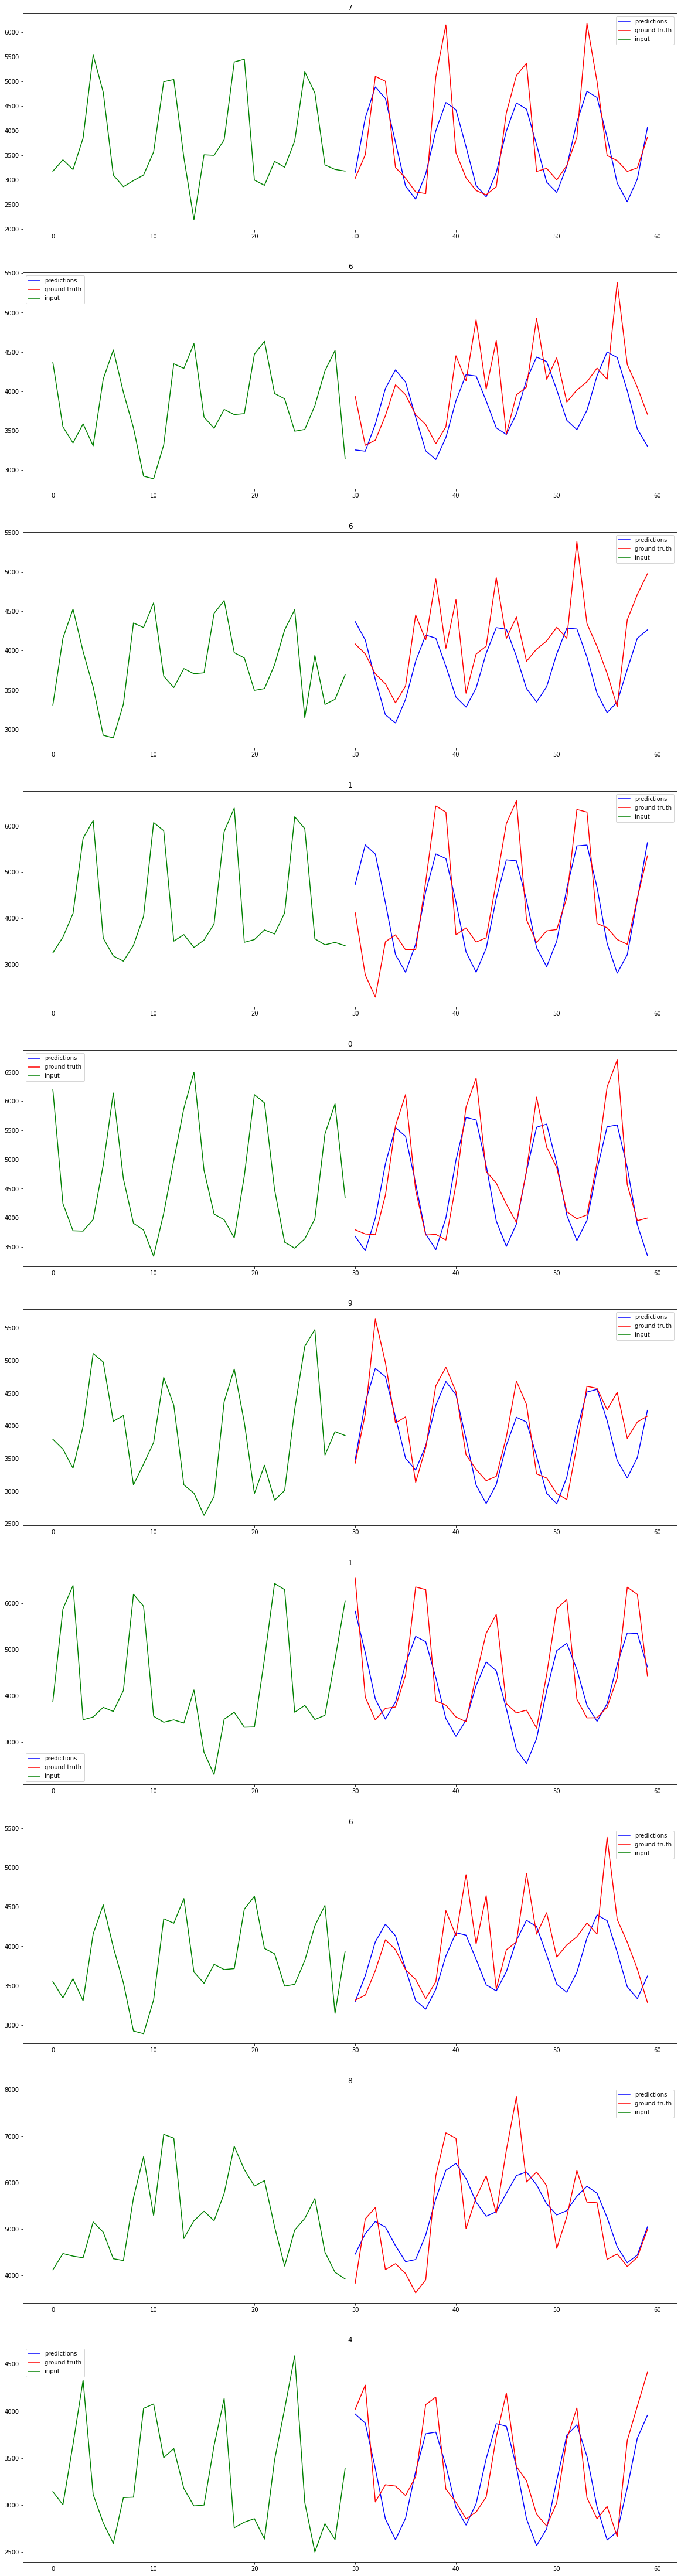

In [18]:
# Loop through samples and plot input, ground truth and prediction
f, axarr = plt.subplots(n_samples, 1, figsize=(20, 80))
for i in range(n_samples):
    series_preds = ss_pred[i, :].squeeze()
    series_trues = ss_true[i, :].squeeze()
    series_inputs = ss_input[i, :].squeeze()

    feat_name = str(ss_class[i].item())
    
    input_len = series_inputs.shape[0]
    pred_gt_len = series_preds.shape[0]
    input_x = np.array([i for i in range(input_len)])
    x = np.array([i for i in range(input_len, input_len+pred_gt_len)])
    axarr[i].plot(x, series_preds, c="blue", label="predictions")
    axarr[i].plot(x, series_trues, c="red", label="ground truth")
    axarr[i].plot(input_x, series_inputs, c="green", label="input")
    axarr[i].legend()
    axarr[i].set_title(feat_name)

In [19]:
mse = mean_squared_error(trues.cpu().numpy(), preds.cpu().numpy())
mae = mean_absolute_error(trues.cpu().numpy(), preds.cpu().numpy())
print(mse, mae)

218092.0 351.04733


In [23]:
# Calculate losses
mse = mean_squared_error(trues.cpu().numpy(), preds.cpu().numpy())
mae = mean_absolute_error(trues.cpu().numpy(), preds.cpu().numpy())

print(f"MSE: {mse} MAE: {mae}")

MSE: 216423.171875 MAE: 350.1058654785156


In [ ]:
#